# Home Assignment 3 - Indices
**Author:** Danis Alukaev <br>
**Email:** d.alukaev@innopolis.university <br>
**Group:** B19-DS-01

# Where is a hospital in Manhattan Downtown?

In this lab we will create 2 vector indices to answer a very simple question: if you are in Manhattan downtown, where is the nearest hospital? We will base our soultion on two sources of data:
- [Points of Interest dataset](https://drive.google.com/file/d/1LUudtCADqSxRl18ZzCzyPPGfhuUo2ZZs/view?usp=sharing). This is a 10% sample of a bigger dataset. Download and uncompress the file.
- [Google Geocoding API](https://developers.google.com/maps/documentation/geocoding/start) or any other [equivalent service](https://gisgeography.com/geocoders/). For Google you will need to obtain a key. **PLEASE DO NOT SUBMIT THE KEY TO MOODLE :)**

# 0.0. Prerequisites

In [ ]:
%pip install pandas numpy matplotlib python-dotenv gdown

In [1]:
import requests
import zipfile
import pickle
import gdown
import json
import math
import os
import gc

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import os
from dotenv import load_dotenv

In [2]:
data_dir = "./data"
poi_path = os.path.join(data_dir, "poi_sample01.pickle")
words_path = os.path.join(data_dir, "words.txt")
world_path = os.path.join(data_dir, "world.csv")

In [3]:
def prepare_env():
    """
    Method that sets up the environment, i.e. creates all necessary directories, 
    downloads files, and prompts to enter your yandex api key.
    """
    data_dir = "./data"
    poi_sample_url = "https://drive.google.com/uc?id=1LUudtCADqSxRl18ZzCzyPPGfhuUo2ZZs&confirm=t"
    words_url = "https://raw.githubusercontent.com/IUCVLab/information-retrieval/main/datasets/words.txt"
    world_url = "https://raw.githubusercontent.com/IUCVLab/information-retrieval/main/datasets/world.csv"

    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    with open(os.path.join(data_dir, "poi_sample_2M.zip"), 'wb') as f:
        r = requests.get(poi_sample_url)
        f.write(r.content)
    
    with zipfile.ZipFile(os.path.join(data_dir, "poi_sample_2M.zip"), 'r') as f:
        f.extractall(os.path.join(data_dir))

    with open(words_path, 'wb') as f:
        r = requests.get(words_url)
        f.write(r.content)

    with open(world_path, 'wb') as f:
        r = requests.get(world_url)
        f.write(r.content)
    
    with open(".env", "w") as f:
        key = input("Enter your yandex api key of form xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx (mine is 1183aa2d-b875-4c87-b545-d2a21a95f94d):")
        f.write(f'KEY="{key}"')

prepare_env()

In [4]:
load_dotenv()
YANDEX_KEY = os.getenv('KEY')

# 0. Prepare the data

In [57]:
def draw_earth(xlim=(-180, +180), ylim=(-90, +90)):
    plt.figure(figsize=(15, 8))
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    # this file also lives in github. Adjust the path if needed.
    df = pd.read_csv(world_path)
    
    for row in df['geojson']:
        js = json.loads(row)
        polys = js['coordinates']
        for poly in polys:
            for pp in poly:
                x, y = [v[0] for v in pp], [v[1] for v in pp]
                plt.plot(x, y, color='gray')

Reading the dataset and storing coordinates in `GEO` matrix:

In [58]:
# replace filename if you want to use another data file
# be careful! 2M points is still a big number and can eat significant amout of memory
with open(poi_path, "rb") as f:
    dataset = pickle.load(f)

# let's sample 20000 of points to draw
step = len(dataset) // 20000

# ! here is the change for 1.4
GEO = np.array([v[0] for v in dataset], dtype=np.float32)
N = len(dataset)
# free the memory
dataset = None
gc.collect()

0

Showing approximate dataset data distribution:

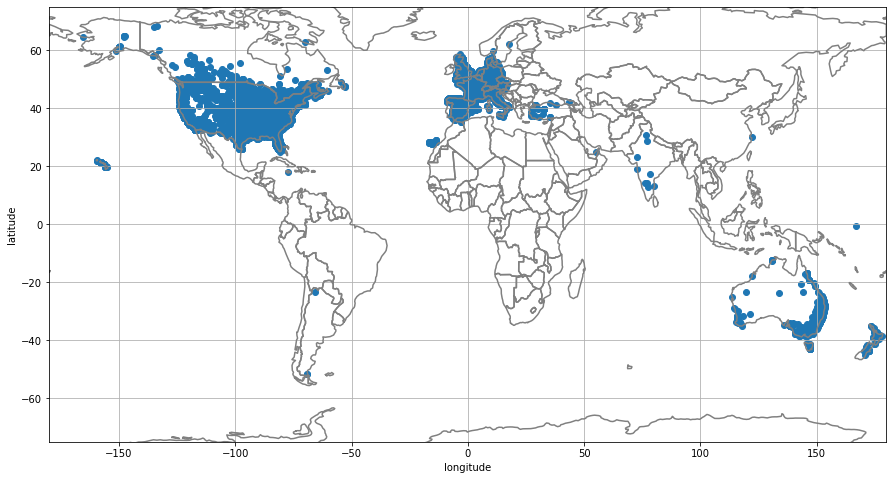

In [59]:
draw_earth(ylim=(-75, 75))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.grid()
plt.scatter(GEO[::step, 0], GEO[::step, 1])
plt.show()

## 0.1. [1 point] Ok. Let's prepare ourselves to read the data from the hard drive

We will prepare id-based shards (data will be distributed into equal files with ranges `[0..capacity-1], [capacity..2*capacity-1], ...`. Each shard will store `capacity` elements. Your task is to complete the implementation with `iterate_dataset` function.

In [60]:
def split_shards(file, folder='shard', capacity=20000):
    if not os.path.exists(folder):
        os.mkdir(folder)
    with open(file, "rb") as f:
        dataset = pickle.load(f)
    nshards = len(dataset) // capacity
    if nshards * capacity < len(dataset):
        nshards += 1
    
    for i in range(nshards):
        with open(f"{folder}/{i}", 'wb') as f:
            part = dataset[i * capacity:(i+1)*capacity]
            pickle.dump(part, f)
    dataset = None
    gc.collect()            

    
def dataset_get(indices, folder='shard', capacity=20000) -> list:
    result = []
    groups = {}
    for i in indices:
        x = i // capacity
        if x not in groups:
            groups[x] = []
        groups[x].append(i)
    for x in groups:
        with open(f"{folder}/{x}", "rb") as f:
            sha = pickle.load(f)
            for i in groups[x]:
                row = sha[i % capacity]
                result.append(row)
    return result


def iterate_dataset(items, folder="shard", capacity=20000):
    """
    Method that returns iterator, which goes through all elements, consequently 
    opening files.

    :param items: number of elements to be retrieved
    :param folder: path to shards
    :param capacity: 
    :yield: next item
    """
    nshards = items // capacity + int(items % capacity > 0)
    for shard_idx in range(nshards):
        with open(os.path.join(folder, str(shard_idx)), "rb") as f:
            shard = pickle.load(f)
            if shard_idx == nshards - 1:
                for item_idx in range(items % capacity):
                    yield shard[item_idx]
                continue
            for item_idx in range(capacity):
                yield shard[item_idx]

In [61]:
split_shards("./data/poi_sample01.pickle")

asserts:

In [62]:
i = 0
for r in iterate_dataset(N):
    i += 1

assert i == N

asserts:

In [63]:
import numpy as np

for i in [137, 40000, 600000]:
    assert np.allclose(GEO[i,:], dataset_get([i])[0][0], atol=5*1e-2), ""

In [64]:
dataset_get([1, 10, 1000234, N-1])

[([-58.4339539, -34.6028583],
  'CreationFlow, Professional, Computer Services. AR, Ciudad de Buenos Aires, Vera 15 3-B'),
 ([13.9706993103, 46.6813430786],
  'Bahnhof Ossiach-Bodensdorf. AT, Bodensdorf, '),
 ([-117.642377, 34.068324],
  'Industrial Labor Management, Professional, Management & Consulting. US, Ontario, 647 E E St'),
 ([28.0354352, -26.1470966],
  'ScoreGrid, Professional, Computer Services. ZA, Johannesburg, 158 Jan Smuts Avenue Rosebank')]

---

# And now the task!
Ok. We are ready to perform the following steps utilizing functions beyond:
1. Build **coordinate search index**. We will use it to obtain POI from the given region.
3. Implement **vector text embedding index** (Annoy, HNSW) to serve semantic queries.
3. Implement **geocoding** with cache. We will use it to obtain city coordinates.
4. Impement search for **double queries: town and location type**.

# 1. Create spacial index for points of interest

We will store dataset rows numbers as values, and coordinates as keys. Please use [KDtree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree) or [BallTree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree) from sklearn.

## 1.1. [5 points] Build the index and return it

Implement the following functions. To get the full grade:
- `build_geospacial_index` should build and return a search tree object: KDTree or BallTree.
- `kNN` accepts a 2D-point, `k` neighbours parameter, and returns **approximate** `k` neighbours (they can be different from the real neighbours).
- `inRadius` accepts a 2D-point, L<sub>2</sub> `radius`, and returns points inside the radius.

In [65]:
from sklearn.neighbors import BallTree

def build_geospacial_index(points, leaf_size=5) -> BallTree:
    """
    Method that builds a search BallTree object. 

    :param points: search space
    :param leaf_size: number of points at which to swithc to brute-force
    """
    tree = BallTree(points, leaf_size=leaf_size)  
    return tree


def kNN(query_point: list, k: int, index: BallTree) -> list:
    """
    Method that returns approximate k neighbours.

    :param query_point: 2D-point
    :param k: number of neighbours to be returned
    :param index: spatial index (e.g. BallTree)
    """
    _query_point = np.array([query_point])
    _, indices = index.query(_query_point, k=k)
    return indices[0]


def inRadius(query_point: list, r: float, index: BallTree) -> list:
    """
    Method that returns approximate k neighbours in a certain radius.

    :param query_point: 2D-point
    :param r: search radius
    :param index: spatial index (e.g. BallTree)
    """
    _query_point = np.array([query_point])
    indices = index.query_radius(_query_point, r=r)
    return indices[0]

In [66]:
spaidx = build_geospacial_index(GEO)

In [67]:
test_id = 13

idx = kNN(GEO[test_id], 10, spaidx)
print(sorted(idx))
assert test_id in idx, "Point itself should be in results"

idx = inRadius(GEO[test_id], 0.0625, spaidx)
print(sorted(idx))
assert test_id in idx, "Point itself should be in results"

[13, 145, 351, 15497, 16642, 20423, 23285, 24681, 26327, 27121]
[13, 145, 351, 15497, 23285, 24681, 26327]


## 1.2. [4 points] Tricky assert

Some keys (coordinates) in the dataset (surprise!) are duplicates. Unfortunately search trees (in basic implemenation) cannot support duplicates. Thus you can follow one of the strategies:
- a key (coordinateS) corresponds to multiple values. This may require additional data strictures.
- improve the data (coordinates) to avoid collisions (e.g. lake sure they never coinside)

Pass the assert to get full points.

In [68]:
points = [1966663, 1480877, 2126566]
for p in points:
    x = GEO[p, :]
    r = kNN(x, 1000, spaidx)
    assert (p in r), "Query did not return itself"

**Discussion** <br> 

All the keys in dataset are unique. The collisions arise due to not sufficient precision of `float16`. Therefore, in section "0. Prepare the data" I have changed type of numpy array `GEO` from `np.float16` to `np.float32`.

## 1.4. [5 points] Range queries?

Ok, you have a **radius query**, but what about **rectangual ranges**? Using the functions you already wrote, please, implement the range query given `north-east` and `south-west` corners. Pass the asserts to get points.

In [84]:
import numpy as np
from scipy.spatial import distance


def descrbe_by_circle(ne, sw):
    """
    Method that computes center, radius of a circle around 
    a rectangle given by corner coordinates.

    :param ne: north-east corner coordinate
    :param sw: south-west corner coordinate
    """
    center = (ne + sw) / 2
    radius = distance.euclidean(ne, sw) / 2
    return center, radius


def get_in_range(ne, sw, spacial_index, GEO) -> list:
    """
    Method that retrieves all the points within a rectangula range
    given by north-east and south-west corners. Returns ids of the 
    rows in given range.

    :param ne: north-east corner coordinate
    :param sw: south-west corner coordinate
    :param spacial_index: spacial_index (e.g. BallTree)
    :param GEO: dataset of points
    """
    _ne, _sw = np.array(ne), np.array(sw)
    center, radius = descrbe_by_circle(_ne, _sw)
    radial_indices = inRadius(center, radius, spacial_index)
    radial_points = GEO[radial_indices]
    indices = radial_indices[((radial_points >= sw) & (radial_points <= ne)).all(axis=1)]
    return indices

In [85]:
def print_starbucks(ids):
    for row in dataset_get(ids):
        if 'Starbucks' in row[1]:
            print(row[1])

asserts:

In [86]:
ids = get_in_range([-73.97, 40.75], [-74.03, 40.70], spaidx, GEO)

assert any(map(
            lambda x: 'Manhattan, 80 Delancey St' in x[1], 
            dataset_get(ids))), "This Starbucks should be in place!"

print_starbucks(ids)

Starbucks Coffee, Coffee & Tea, . US, Hoboken, 51 Newark St
Starbucks Coffee, Coffee & Tea, . US, New York, 55 Liberty St
Starbucks Coffee, Coffee & Tea, . US, New York, 150 Varick St
Starbucks Coffee, Coffee & Tea, . US, New York, 378 Avenue of The Americas
Starbucks Coffee, Coffee & Tea, . US, New York, 4 W 21st St
Starbucks, Restaurant, . US, Manhattan, 195 Broadway
Starbucks, Coffee & Tea, . US, Manhattan, 80 Delancey St
Starbucks, Coffee & Tea, . US, Manhattan, 471 Broadway


# 2. Geocoding

In this block we will learn, how to convert text place names into coordinate rectangles.

## 2.1. [5 points] Implement geocoding
which returns north-eastern and south-western points of the place. Pass asserts.

In [17]:
import requests

# this function returns a pair of tuples: NE and SW corners.
def get_town_range_coordinates(town: str, google_maps_api_key: str) -> tuple:
    api = "https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}"
    # TODO your code here.
    # NB you can use any other geocoding tool, e.g. yandex: https://yandex.ru/dev/maps/geocoder/
    return NE, SW

If needed, request your key here: https://developers.google.com/maps/documentation/geocoding/get-api-key

Note, that from local machine you may (!) need to have VPN enabled. For colab this should work smoothly.

In [ ]:
my_google_maps_api_key = open('google.key', 'r').read()

asserts:

In [19]:
p = get_town_range_coordinates('Pittsburgh downtown', my_google_maps_api_key)
print(p)
assert p[1][0] <= -80. <= p[0][0] and p[1][1] <= 40.44 <= p[0][1] 

((-79.9850177, 40.4470826), (-80.0132775, 40.433569))


## 2.2. [5 points] Town queries

Now, having a range query and geocoding, we can implement town-queries!

In [20]:
# should return dataset indices
def get_in_town(town, index, GEO, maps_api_key) -> list:
    # TODO your code here!
    return [0, 1, 2]

In [22]:
ids = get_in_town('Pittsburgh downtown', spaidx, GEO, my_google_maps_api_key)

assert any(map(
            lambda x: 'US, Pittsburgh, 810 River Ave' in x[1], 
            dataset_get(ids))), "This Starbucks should be in place!"

print_starbucks(ids)

Starbucks Coffee, Utilities, Mobile Phone. US, Pittsburgh, 1719 Penn Ave
Starbucks Coffee, Coffee & Tea, . US, Pittsburgh, 810 River Ave


# 3. Text search

We are done with geography, but we have no clear method to search for categories. What if we prepare vector index of location names?

In [ ]:
# !pip install spacy
# !python -m spacy download en_core_web_md

In [ ]:
import spacy
nlp = spacy.load('en_core_web_md')
names = []

## 3.1. [5 points] Embedding

Here is the trick. If you use any embedding model "as it is", it may take some hours to prepare 2M embeddings. It's ok if you can wait for **3 points**, but...

To get full points, please think, how you can speed up the process with embedding to less than 5 minutes?

HINT: spacy model `nlp` has a [dictionary for word embeddings](https://spacy.io/api/vocab). You can access `nlp.vocab[word].vector` to get word embedding, `nlp.vocab.strings` map stores integer indices.

In [26]:
import numpy as np

# if you need most frequent english words for some reason.
WORDS = set([a.strip() for a in open('../../datasets/words.txt', 'r').readlines()])

def embed(text, nlp):
    # TODO your code here. This should return a vector (300,)
    pass

In [27]:
from tqdm import tqdm
import gc
import numpy as np

embeddings = np.zeros((N, 300), dtype=np.float16)

for i, item in enumerate(tqdm(iterate_dataset(N), total=N)):
    name = item[1].split('.')[0]
    emb = embed(name, nlp)
    if emb is not None:
        embeddings[i, :] = emb

gc.collect()

  0%|▏                                                                       | 7056/2173512 [00:00<01:10, 30796.53it/s]<ipython-input-26-d8bb31a9066a>:18: RuntimeWarning: invalid value encountered in true_divide
  return emb / np.linalg.norm(emb)
100%|█████████████████████████████████████████████████████████████████████| 2173512/2173512 [01:09<00:00, 31481.28it/s]


27

## 3.2. [10 points] Vector index

Here we will build vector index for our embeddings. I want to warn Windows users, that they can observe problems with installing Faiss and HNSWlib. Still this is not the reason not to try :)
Choose **one of the libraries** and fulfill the requirements:
1. If you choose [FAISS](https://faiss.ai/). Get started with [installation](https://faiss.ai/#install) and this [tutorial](https://github.com/facebookresearch/faiss/wiki/Getting-started). To get full points your index must use [Product Quantization](https://github.com/facebookresearch/faiss/wiki/Lower-memory-footprint): 50 subvectors, 8 bits (1 byte) each. Use custom `nprobe` parameter equal to 23. Number or Voronoi cells is `65536`. Refer to [this document](https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index#if-1m---10m-ivf65536_hnsw32) to understand recommendations.
2. If you use [HNSWlib](https://github.com/nmslib/hnswlib) (or [nmslib](https://github.com/nmslib/nmslib)) then follow these requirements. Use `cosine` metric for index construction, maximum number of outgoing connections (max outdegree) in the graph is 16, `ef` parameter at construction time should be `250`. Some useful information is given [here](https://github.com/nmslib/nmslib/blob/master/manual/methods.md).
3. For [Annoy](https://github.com/spotify/annoy) you should cosine distance for the space (if vectors are normed, you can use dot product intead), use all CPU cores at construction time. Build the index on right on disk, then load. Your index should consist of 37 trees.

**NB** If you run on not-very-modern hardware (e.g. your RAM is less then 8GB), then you'd better reduce dataset size (e.g. take a specific region only like US east cost). You can also reduce other parameters only for the sake of RAM efficiency, but please specify and justify your decisions.

e.g.
```    
roi = set(get_in_range([-68.645945, 43.163175], [-80.461502, 37.097044], spaidx, GEO))
```


**HINT** You can remove `embeddings` array and call `gc.collect()` before loading index to RAM.

**HINT2** Should you index vectors with $[0]^N$ values?

In [ ]:
embedding_index = None

In [ ]:
import numpy as np

def get_vector_index():
    # TODO returns index object
    # Write your code here
    pass


def get_kNN_embeddings(embedding, k, index):
    # TODO write your kNN queries here
    pass

In [30]:
embedding_index = get_vector_index()

  6%|████▏                                                               | 134600/2173512 [00:00<00:01, 1296327.73it/s]

Points in ROI: 303210


100%|████████████████████████████████████████████████████████████████████| 2173512/2173512 [00:10<00:00, 208044.26it/s]


Vectors added. Building...
Index construction finished, 303210
index built
Memory freed 35


In [ ]:
result = get_kNN_embeddings(embed('pharmacy', nlp), 1000, embedding_index)
assert len(result) == 1000

# 4. [5 points] And now we want to have this together!

Say no more:

In [35]:
def find(town, query) -> list:
    # TODO should return list of data items, with coordinates and texts
    pass

In [42]:
items = find('Manhattan downtown', 'hospital')
print(items[:20])
xy = np.array([row[0] for row in items])

Cache Hit!
[([-73.988956, 40.723471], 'Naturo Medical Health Care PC, Health Services, Doctor. US, New York, 39 E 1 St'), ([-73.982753, 40.733923], 'Jane Algus, Health Services, Doctor. US, New York, 301 E 17 St'), ([-73.996201, 40.713591], 'Lower East Side Svc Ctr, Health Services, Hospital. US, New York, 62 E Broadway'), ([-74.009347, 40.709391], 'David Sprung DDS, Health Services, Doctor. US, New York, 6 Maiden Ln'), ([-73.987968, 40.723942], 'Perfect Body Health System, Health Services, Health Practitioner. US, New York, 25 1 Ave'), ([-73.982753, 40.733923], 'Anthony Antonacci MD, Health Services, Doctor. US, New York, 350 E 17 St'), ([-74.003332, 40.729397], 'Limphedema Preventive Care, Health Services, Clinic. US, New York, 10 Downing St'), ([-73.982753, 40.733923], 'Miriam Lane MD, Health Services, Doctor. US, New York, 301 E 17 St'), ([-74.002307, 40.715365], 'N Y City Health & Hospital, Health Services, Hospital. US, New York, 125 Worth St'), ([-73.989031, 40.714225], 'Joseph 

Cache Hit!


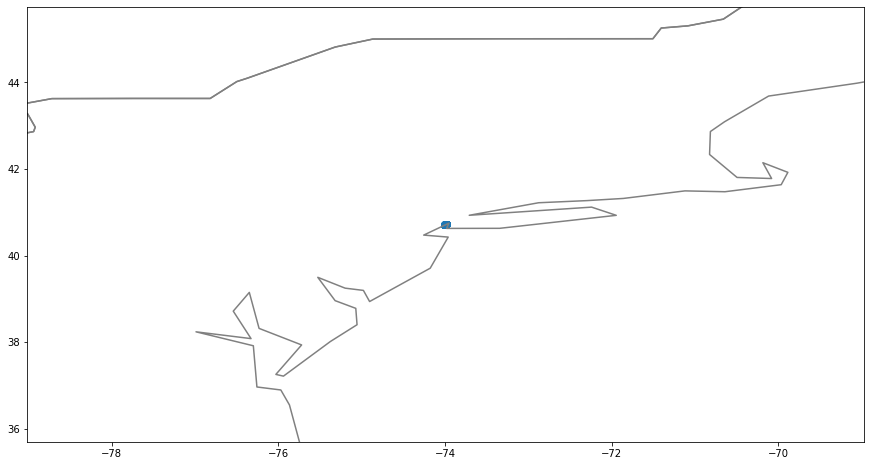

In [44]:
# get_town_range_coordinates_cached is fixed accroding to https://t.me/c/1784134413/236

NE, SW = get_town_range_coordinates('Manhattan downtown', my_google_maps_api_key)
draw_earth(xlim=(SW[0] - 5, NE[0] + 5), ylim=(SW[1] - 5, NE[1] + 5))
plt.scatter(xy[:, 0], xy[:, 1])
plt.show()